In [148]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.conftest import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


# The Olivetti Dataset

In [4]:
faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/adamscarlat/scikit_learn_data


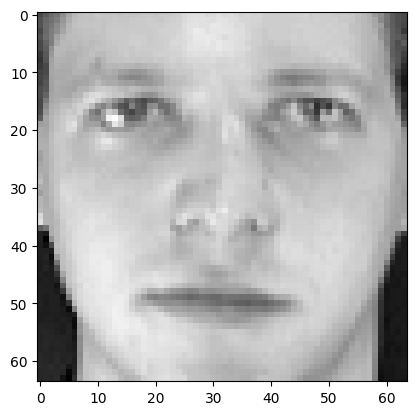

In [62]:
# 400x64x64 images of faces
images = faces.images

# Images flattened - 400x4096 
X = faces.data
y = faces.target

plt.imshow(images[0], cmap="gray")

In [29]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_idx, test_idx in strat_split.split(X, y):
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

print ("Train X,y shape: ", X_train.shape, y_train.shape)
print ("Test X,y shape: ", X_test.shape, y_test.shape)


Train X,y shape:  (320, 4096) (320,)
Test X,y shape:  (80, 4096) (80,)


In [43]:
inertias = []
silhouettes = []
step = 10
for k in range(5, 150, step):
  print ("k: ", k)
  kmeans = KMeans(n_clusters=k, n_init=100)
  kmeans.fit(X_train)
  inertias.append(kmeans.inertia_)
  if k > 1:
    silhouettes.append(silhouette_score(X_train, kmeans.labels_))

k:  5
k:  15
k:  25
k:  35
k:  45
k:  55
k:  65
k:  75
k:  85
k:  95
k:  105
k:  115
k:  125
k:  135
k:  145


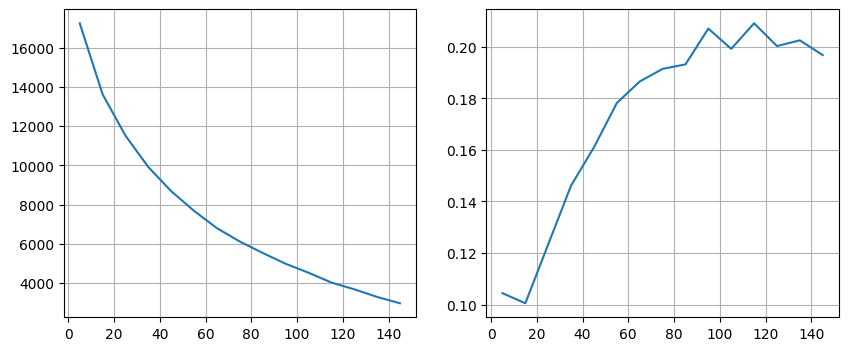

In [56]:
k_range = np.arange(5, 150, step)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  

axs[0].plot(k_range, inertias)
axs[0].grid()
axs[1].plot(k_range, silhouettes)
axs[1].grid()

In [59]:
best_k_sil = np.argmax(silhouettes) * 10
best_k_sil

110

In [60]:
kmeans = KMeans(n_clusters=110, n_init=50)
kmeans.fit(X_train)

KMeans(n_clusters=110, n_init=50)

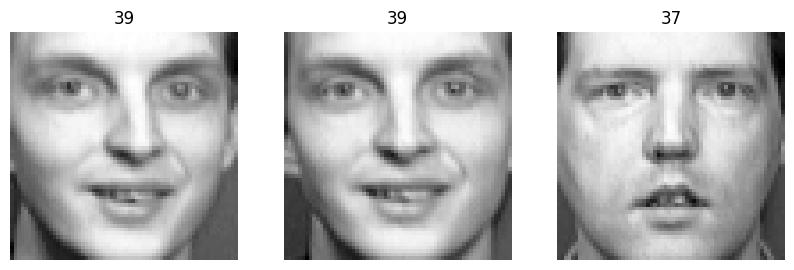

In [83]:
# Plotting a few faces from same cluster
cluster_n = 88
cluster_faces = X_train[kmeans.labels_ == cluster_n]
cluster_labels = y_train[kmeans.labels_ == cluster_n]

# no more than 5 per cluster
sample_n = 5 if cluster_faces.shape[0] > 5 else cluster_faces.shape[0]

plt.figure(figsize=(10, sample_n * 1.1))
for i in range(sample_n):
  #fig, axs = plt.subplots(1, sample_n, figsize=(10, 4))
  plt.subplot(1, sample_n, i+1)
  plt.imshow(cluster_faces[i].reshape(64, 64), cmap="gray")
  plt.axis("off")
  plt.title(cluster_labels[i])





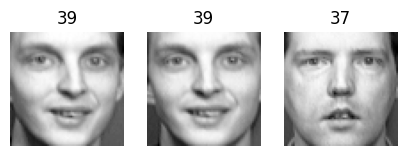

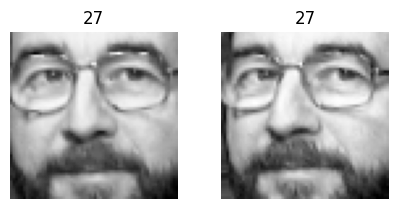

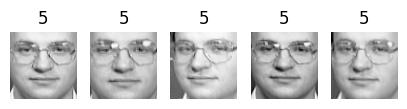

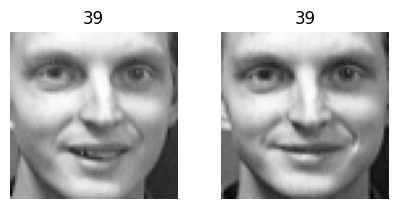

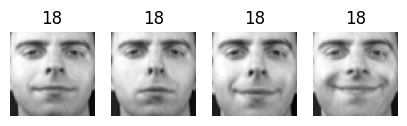

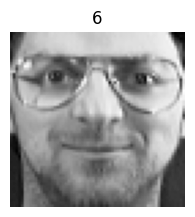

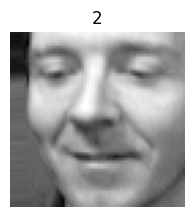

In [127]:
cluster_ns = [88, 34, 22, 54, 23, 44, 100]
X_samples = []
y_samples = []
for cluster_n in cluster_ns:
  X_samples.append(X_train[kmeans.labels_ == cluster_n])
  y_samples.append(y_train[kmeans.labels_ == cluster_n])

for row, (X_sample, y_sample) in enumerate(zip(X_samples, y_samples)):
  sample_n = 5 if X_sample.shape[0] > 5 else X_sample.shape[0]
  n_rows = len(X_sample)
  plt.figure(figsize=(5, n_rows * 5))
  for i in range(sample_n):
    plt.subplot(n_rows * 2, sample_n, i+1)
    plt.imshow(X_sample[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title(y_sample[i])
  plt.show()   



### Using K Means for dim reduction

In [130]:
# Starting with a random forest classifier on the entire dataset for a baseline
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.score(X_test, y_test)

0.9375

In [136]:
# Creating a reduced dataset (using the best KMeans from before)
X_train_kdists = kmeans.transform(X_train)
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_kdists, y_train)

# Way worse...
X_test_kdists = kmeans.transform(X_test)
forest_clf.score(X_test_kdists, y_test)

0.7375

In [139]:
X_train.shape

(320, 4096)

In [141]:
# Adding the reduced features to the image dataset and retraining
X_train_with_dists = np.c_[X_train, X_train_kdists]
X_test_with_dists = np.c_[X_test, X_test_kdists]

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_with_dists, y_train)

# Same...
forest_clf.score(X_test_with_dists, y_test)

0.9375

### Gaussian mixture models on the faces dataset

In [147]:
# Reducing dims of the dataset (too slow)

pca = PCA(n_components=0.99, random_state=42)
X_train_reduced = pca.fit_transform(X_train)

print ("Before PCA: ", X_train.shape)
print ("After PCA: ", X_train_reduced.shape)

Before PCA:  (320, 4096)
After PCA:  (320, 221)


In [150]:
# Fitting a Gaussian mixture

gm = GaussianMixture(n_components=10, n_init=10)
gm.fit(X_train_reduced)

GaussianMixture(n_components=10, n_init=10)

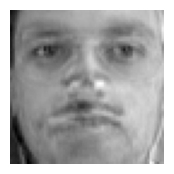

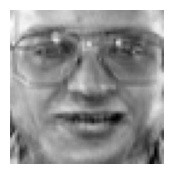

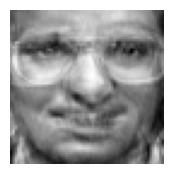

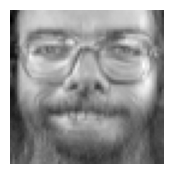

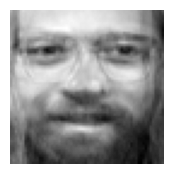

In [181]:
# Using the GM to sample new faces

samples = gm.sample(5)
# Since we used PCA, we need to inverse the transform back to original dimensions
samples_inveresed = pca.inverse_transform(samples[0])
for i, sample in enumerate(samples_inveresed):
  plt.figure(figsize=(2,2))
  plt.imshow(sample.reshape(64,64), cmap="gray")
  plt.axis("off")

### Using PCA reconstruction error to detect anomalies

In [187]:
# Getting the reconstruction error for legit images (the train set)
X_train_reduced_reconstructed = pca.inverse_transform(X_train_reduced)
reconstruction_error_X_train = np.mean(np.square(X_train - X_train_reduced_reconstructed))
reconstruction_error_X_train


0.0001890235

In [194]:
#!! Not sure which face images I should be checking, the samples reconstruction error is much lower...

# Getting the reconstruction error for sampled images (not real ones)
samples_reduced = pca.transform(samples_inveresed)
samples_reconstructed = pca.inverse_transform(samples_reduced)
reconstruction_error_samples = np.mean(np.square(samples_inveresed - samples_reconstructed))
reconstruction_error_samples

3.793686644629877e-14